# Модель взаимодействия посадочной опоры многоразовой ступени РН Falcon-9 с поверхностью земли

Подключаем библиотеки

In [178]:
# Именованный кортеж ждя передачи в функции группы данных
from collections import namedtuple
# Массивы и матрицы
import numpy as np
# Численное интегрирование дифференциальных уравнений
from scipy.integrate import solve_ivp
# Графики
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Настройка свойств графиков "по умолчанию"
pylab.rcParams.update({'legend.fontsize': 9, 'figure.figsize': (6, 4), 'axes.labelsize': 9,
         'axes.titlesize':9, 'xtick.labelsize':9,'ytick.labelsize':9})

Функция правой части

$$
    \ddot{s} = \frac{4 a^2 \sqrt{l^2-h^2}}{m s^2 \left(\sqrt{l^2-h^2}-\mu  h\right)}D-\frac{a g+\dot s^2}{s}
$$

$s$ - длина демпфирующего подкоса, $m$ - масс ступени в момент посадки, $D$ - сила создаваемая демпфером,    


In [96]:
def dydt(t, y, p):  
    # Длина демпфера
    s     = y[0]
    # Скорость изменения длины демпфера ds/dt
    ds    = y[1]    
    # Высота 
    h     = np.sqrt((s**2 - p.l**2 - p.a**2)/(2*p.a))    
    # x
    x     = np.sqrt(p.l**2-h**2)     
    D = p.D
    # dv/dt =   
    d2s   = 4*p.a*p.a*D*x/(p.mass*(x-p.mu*h)*s*s) - (p.a*p.g+ds*ds)/s 
    return np.array([ds,d2s])

def event_ds_eq_0(t, y):
    # Функция-"детектор", передаваемая в интегратор (параметр events), 
    # для определения времени достижения нулевой скорости вертикальной скорости 
    # остановки процесса интегрирования    
    return y[1]

# функция определяется условие h = 0 при движении "вниз"
event_ds_eq_0.direction = 1
# функция-детектор активна
event_ds_eq_0.terminal  = True  

In [259]:
params = namedtuple("params", "l a mass g D")
# Масса ступени
params.mass = 33000 
# Расстоянием между шарнирами подкосов
params.a    = 3.2
# Длина подкоса постоянной длины
params.l    = 6.1
# Ускорение свободного падения
params.g    = 9.807
# Коэффициент трения
params.mu   = 0.4
# Сила, создаваемая демпфером
params.D    = 25000*9.807*1

# Начальные условия:
# начальная вертикальная скорость
dh0 = -3
# начальная длина демпфирующего подкоса
s0  = 8.09329
# начальная скорость деформации демпфера
ds0 = dh0*params.a/s0

print((params.mass*params.g/4)*s0/params.a)

# Запуск процесса численного интегрированиая
# Без учета трения
sol      = solve_ivp(lambda t,y: dydt(t,y,params), [0, 10], [s0, ds0], method='LSODA', events = [event_ds_eq_0], rtol = 1e-9)
# С учетом трения
params.mu   = 0.4
sol_mu01 = solve_ivp(lambda t,y: dydt(t,y,params), [0, 10], [s0, ds0], method='LSODA', events = [event_ds_eq_0], rtol = 1e-9)


# Определяем таблицу изменения высоты 
h        = (sol.y[0]**2-params.l**2-params.a**2)*0.5/params.a
h_mu01   = (sol_mu01.y[0]**2-params.l**2-params.a**2)*0.5/params.a
# и вертикальной скорости
dh       = sol.y[0]*sol.y[1]/params.a
dh_mu01  = sol_mu01.y[0]*sol_mu01.y[1]/params.a
# и время остановки (достижение нулевой скорости)
tmax      = sol.t.max()
tmax_mu01 = sol_mu01.t.max()

204628.08874921873


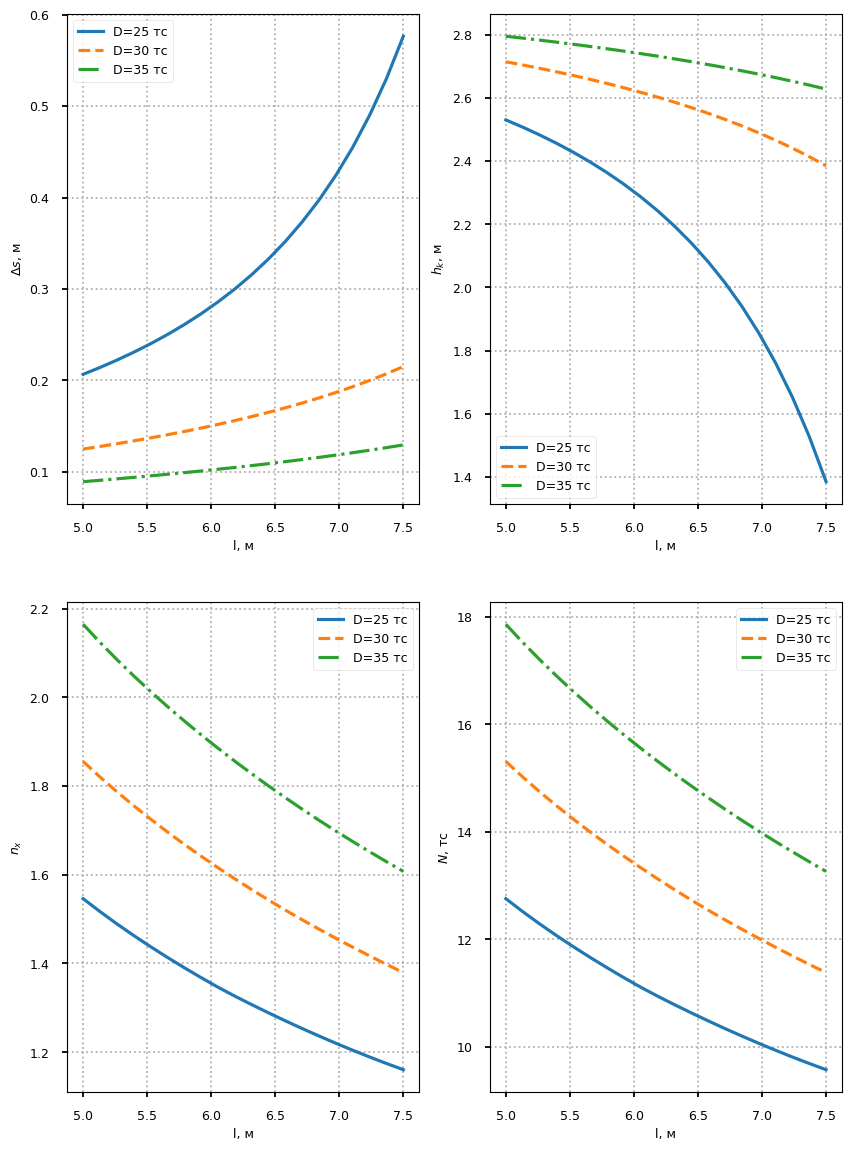

In [270]:
def get_sol_4phi0(p, h0, l, D):    
    p.l      = l
    p.s0     = np.sqrt(l*l+p.a*p.a+2*p.a*h0)
    dh0      = -2.0
    ds0      = dh0*p.a/p.s0    
    p.D      = D
    p.mu     = 0.2
    sol      = solve_ivp(lambda t,y: dydt(t,y,p), [0, 5], [p.s0, ds0], method='LSODA', events = [event_ds_eq_0], rtol = 1e-9)
    h        = (sol.y[0]**2-p.l**2-p.a**2)*0.5/p.a    
    dh       = sol.y[0]*sol.y[1]/p.a
    tmax     = sol.t.max()
    ds       = sol.y[1]
    s        = sol.y[0]
    x        = np.sqrt(p.l**2-h**2)   
    d2s      = 4*p.a*p.a*p.D*x/(p.mass*(x-p.mu*h)*s*s) - (p.a*p.g+ds*ds)/s     
    d2h      = ds**2/p.a + (s*d2s)/p.a    
    N        = p.mass*(9.807+d2h)/4.0 
    return (p.s0, sol.t, s, h, dh, d2h, N)

def ds_of_l(l,h,D):
    (s0,t,st,ht,dht,d2ht, N) = get_sol_4phi0(params, h, l, D);
    return (max(st)-min(st),ht[-1],max(d2ht), max(N))

li = np.linspace(5.0,7.5,20)
dsi25 = np.array([ds_of_l(x,3.0,25*9807) for x in li])
dsi30 = np.array([ds_of_l(x,3.0,30*9807) for x in li])
dsi35 = np.array([ds_of_l(x,3.0,35*9807) for x in li])

plt.figure(figsize=[10,14])
plt.subplot(2,2,1)
plt.plot(li,dsi25[:,0])
plt.plot(li,dsi30[:,0],'--')
plt.plot(li,dsi35[:,0],'-.')
plt.xlabel('l, м');plt.ylabel('$\Delta s$, м');plt.grid(ls=':')
plt.legend(['D=25 тс','D=30 тс','D=35 тс'])

plt.subplot(2,2,2)
plt.plot(li,dsi25[:,1])
plt.plot(li,dsi30[:,1],'--')
plt.plot(li,dsi35[:,1],'-.')
plt.xlabel('l, м');plt.ylabel('$h_k$, м');plt.grid(ls=':')
plt.legend(['D=25 тс','D=30 тс','D=35 тс'])

plt.subplot(2,2,3)
plt.plot(li,(dsi25[:,2]+9.807)/9.807)
plt.plot(li,(dsi30[:,2]+9.807)/9.807,'--')
plt.plot(li,(dsi35[:,2]+9.807)/9.807,'-.')
plt.xlabel('l, м');plt.ylabel('$n_x$');plt.grid(ls=':')
plt.legend(['D=25 тс','D=30 тс','D=35 тс'])

plt.subplot(2,2,4)
plt.plot(li,dsi25[:,3]/9807)
plt.plot(li,dsi30[:,3]/9807,'--')
plt.plot(li,dsi35[:,3]/9807,'-.')
plt.xlabel('l, м');plt.ylabel('$N$, тс');plt.grid(ls=':')
plt.legend(['D=25 тс','D=30 тс','D=35 тс'])

6.249457216358534

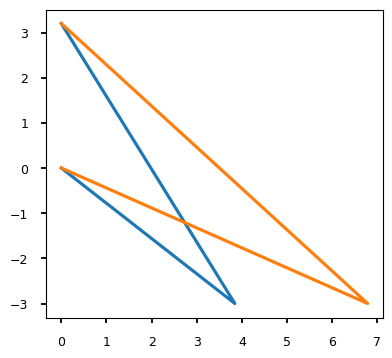

In [261]:
plt.plot([0,np.sqrt(5.0**2-params.a**2) ,0],[0,-3,params.a])
plt.plot([0,np.sqrt(7.5**2-params.a**2) ,0],[0,-3,params.a])
plt.gca().set_aspect('equal')
(np.sqrt(7.5**2-params.a**2)+4.11/2)*np.sqrt(2)/2.0

In [269]:
a=3.0; l=5; D=4.11; h0 = 3; xc = 11;
w = (np.sqrt(l**2-a**2)+D/2)*np.sqrt(2)/2.0;
dh = np.sqrt(w**2+(h0+xc-1.0)**2)-(h0+xc-1.0)
[dh*32700*9.807, 32700*2*2*0.5]

[220284.49608470945, 65400.0]

C:\Users\kidin\AppData\Local\Temp\ipykernel_44492\2126296773.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


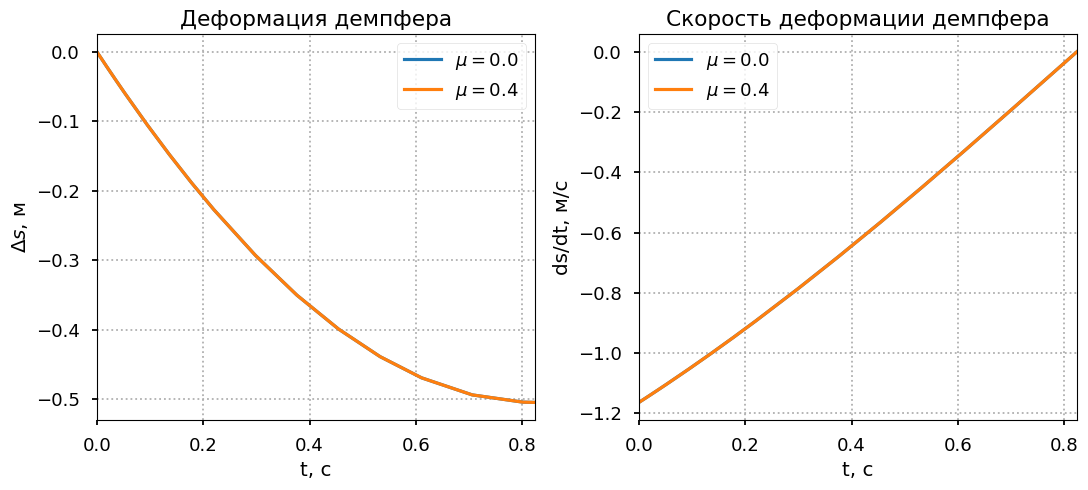

In [150]:
    plt.style.use("seaborn-talk")
    plt.figure(figsize=[11,5])

    plt.subplot(121)
    plt.plot(sol.t,sol.y[0]-s0);
    plt.plot(sol_mu01.t,sol_mu01.y[0]-s0);
    plt.xlabel('t, c'); plt.ylabel('$\Delta s$, м');plt.xlim([0,tmax])
    plt.grid(True,ls=':')
    plt.legend(['$\mu=0.0$','$\mu=0.4$'])
    plt.title('Деформация демпфера')

    plt.subplot(122)
    plt.plot(sol.t,sol.y[1]);
    plt.plot(sol_mu01.t,sol_mu01.y[1]);
    plt.xlabel('t, c'); plt.ylabel('ds/dt, м/c'); plt.xlim([0,tmax])
    plt.grid(True,ls=':')
    plt.legend(['$\mu=0.0$','$\mu=0.4$'])
    plt.title('Скорость деформации демпфера')
    plt.tight_layout()
    plt.savefig('Falcon_s_ds.png',dpi=160)

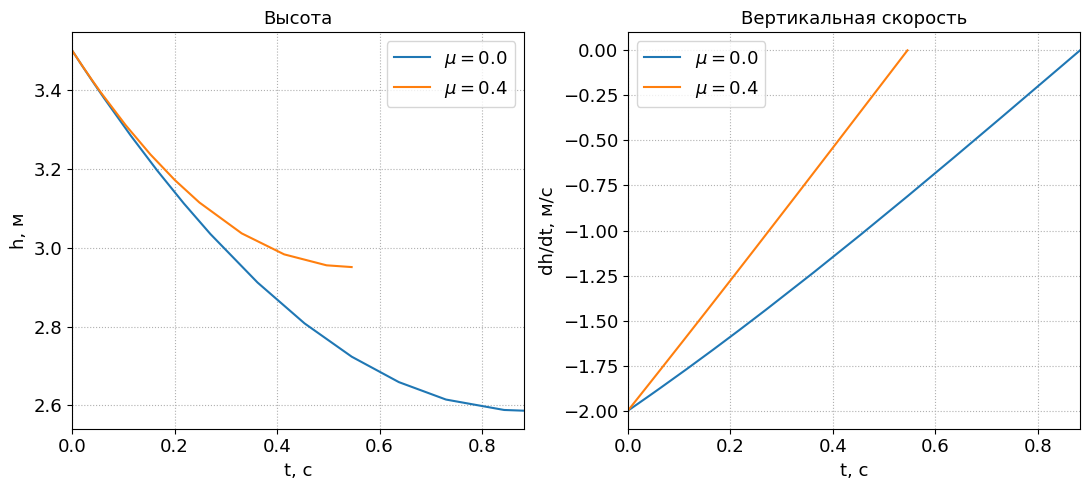

In [4]:
    plt.figure(figsize=[11,5])

    plt.subplot(121)
    plt.plot(sol.t,h);
    plt.plot(sol_mu01.t,h_mu01);
    plt.xlabel('t, c'); plt.ylabel('h, м');plt.xlim([0,tmax])
    plt.grid(True,ls=':')
    plt.legend(['$\mu=0.0$','$\mu=0.4$'])
    plt.title('Высота')

    plt.subplot(122)
    plt.plot(sol.t,dh);
    plt.plot(sol_mu01.t,dh_mu01);
    plt.xlabel('t, c'); plt.ylabel('dh/dt, м/c');plt.xlim([0,tmax])
    plt.grid(True,ls=':')
    plt.legend(['$\mu=0.0$','$\mu=0.4$'])
    plt.title('Вертикальная скорость')
    plt.tight_layout()
    plt.savefig('Falcon_h_dh.png',dpi=160)

### Энергия

Cила смятия демпфера $ D $ при заданной его деформации и начальной вертикальной скорости ступени:

$$
D  = \frac{m g}{4 a}\left[s_0 + \frac{V_0^2 a}{2 g \Delta s} - \frac{\Delta s}{2} \right]
$$

Энергия поглощаемая демпфером одной посадочной опоры:

$$
    E_D  = \frac{m g}{4 a}\left[s_0 + \frac{V_0^2 a}{2 g \Delta s} - \frac{\Delta s}{2} \right] \Delta s
$$

In [7]:
D  = lambda x,V0 : params.mass*params.g/(4*params.a)*(s0+V0**2*params.a/(2*params.g*x)-x/2)
Ed = lambda x,V0 : params.mass*params.g/(4*params.a)*(s0+V0**2*params.a/(2*params.g*x)-x/2)*x

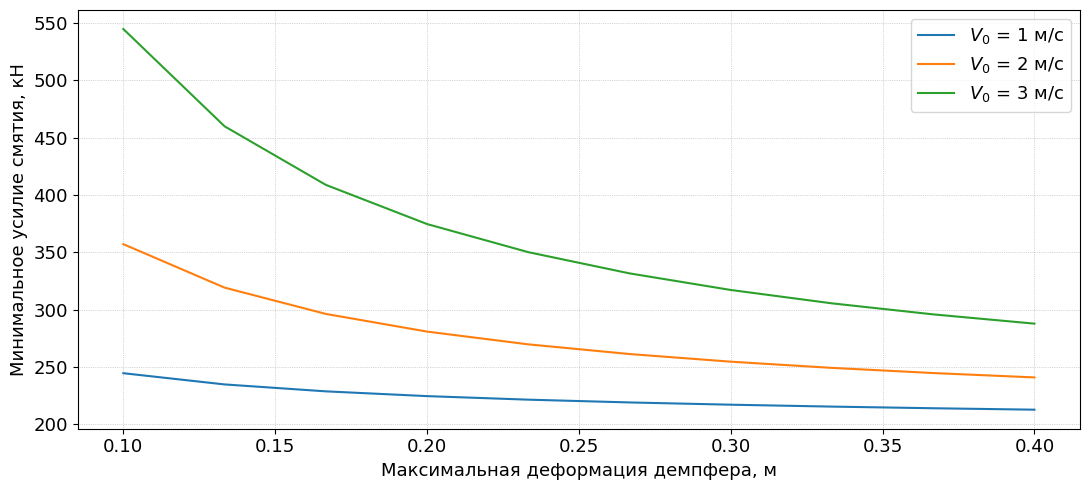

In [9]:
ds_list = np.linspace(0.1,0.4,10)
D1 = [D(x,1)*0.001 for x in ds_list]
D2 = [D(x,2)*0.001 for x in ds_list]
D3 = [D(x,3)*0.001 for x in ds_list]

plt.figure(figsize=[11,5])
plt.plot(ds_list,D1);
plt.plot(ds_list,D2);
plt.plot(ds_list,D3);
plt.grid(True, lw=0.5, zorder=0,ls=':')
plt.xlabel('Максимальная деформация демпфера, м')
plt.ylabel('Минимальное усилие смятия, кН')
plt.legend(['$V_0$ = 1 м/с','$V_0$ = 2 м/с','$V_0$ = 3 м/с'])
plt.tight_layout()
plt.savefig('Falcon_D.png',dpi=160)

In [162]:
Ed(sol.y[0,0]-sol.y[0,-1],dh0)

82181.1468535728

In [163]:
250*0.33

82.5